In [1]:
import numpy as np
import pandas as pd
from itertools import permutations
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generate_dataset(sigma: float):
    samples1 = np.random.multivariate_normal(\
        np.array([-1, -1]), sigma * np.array([[2, 0.5], [0.5, 1]]), 100)
    samples2 = np.random.multivariate_normal(\
        np.array([1, -1]), sigma * np.array([[1, -0.5], [-0.5, 2]]), 100)
    samples3 = np.random.multivariate_normal(\
        np.array([0, 1]), sigma * np.array([[1, 0], [0, 2]]), 100)
    dataset = np.concatenate((samples1, samples2, samples3))
    labels = [0] * 100 + [1] * 100 + [2] * 100
    return (dataset, np.array(labels))

In [3]:
def km_clustering(X: np.array, K: int) -> (np.array, np.array):
    # randomly select k centroids
    dbounds = [(np.min(X[:, i]), np.max(X[:, i])) for i in range(X.shape[1])]
    centers = np.array([[np.random.random_sample() * (dbounds[j][1] - dbounds[j][0]) + dbounds[j][0] \
                for j in range(len(dbounds))] for i in range(K)])
    converged = False
    Y = np.zeros(X.shape[0])
    iteration = 0
    while not converged:
        iteration += 1
        change = False
        # assign each x to a centroid
        for i in range(len(X)):
            prev_y = Y[i]
            x = X[i]
            distances = np.linalg.norm(centers - x, axis=1)
            closest_center = np.argmin(distances)
            Y[i] = closest_center
            if Y[i] != prev_y:
                change = True
        # update each centroid
        for k in range(len(centers)):
            cluster_points = [X[j] for j in np.where(Y == k)[0]]
            centers[k] = np.mean(cluster_points, axis=0)
        # if no centroid assignment changed, we've converged
        if not change:
            converged = True
            print('Converged after ' + str(iteration) + ' iterations.')
    return (centers, Y)

Converged after 3 iterations.


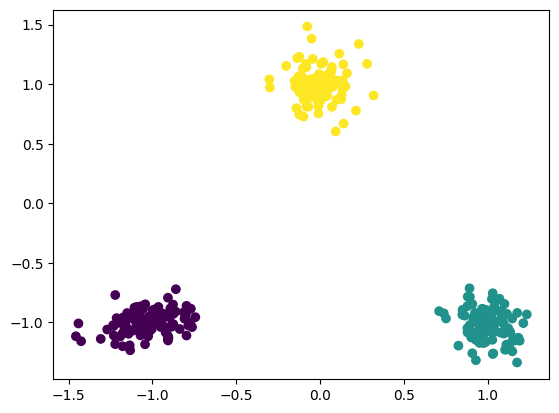

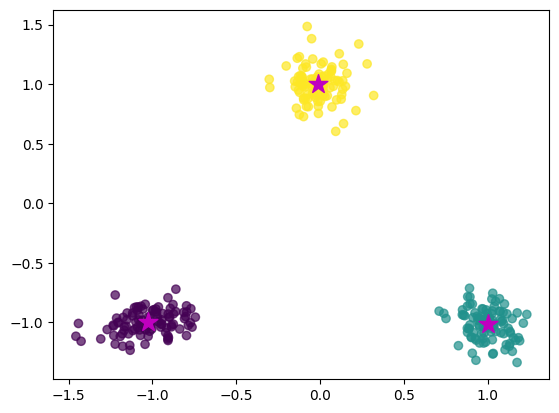

Sigma: 0.01	Accuracy: 1.0
Converged after 15 iterations.


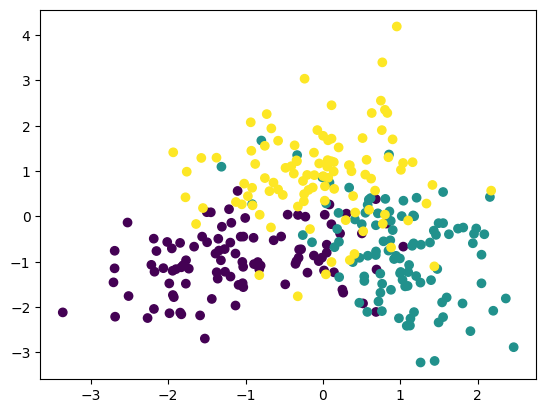

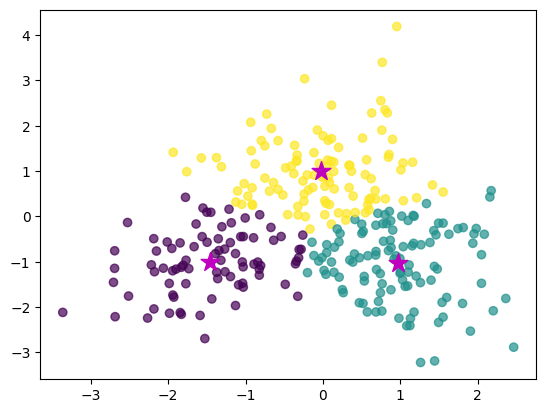

Sigma: 0.5	Accuracy: 0.7866666666666666
Converged after 8 iterations.


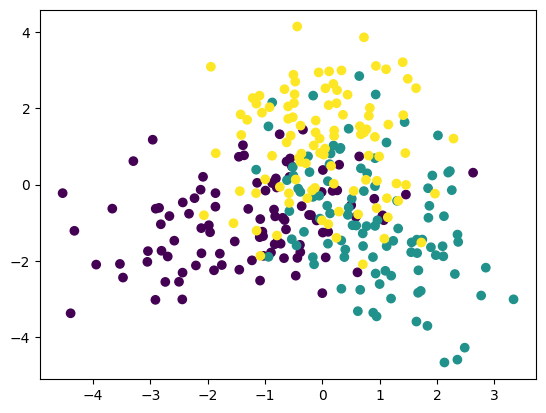

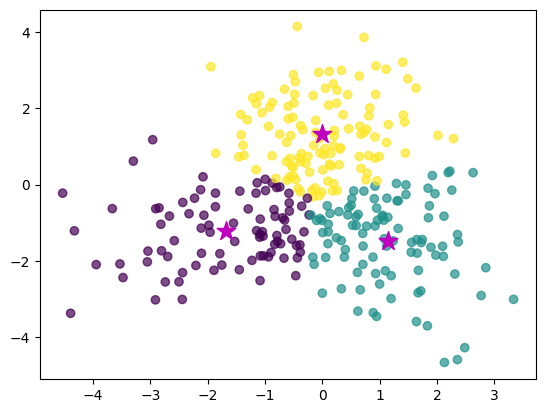

Sigma: 1	Accuracy: 0.6933333333333334
Converged after 13 iterations.


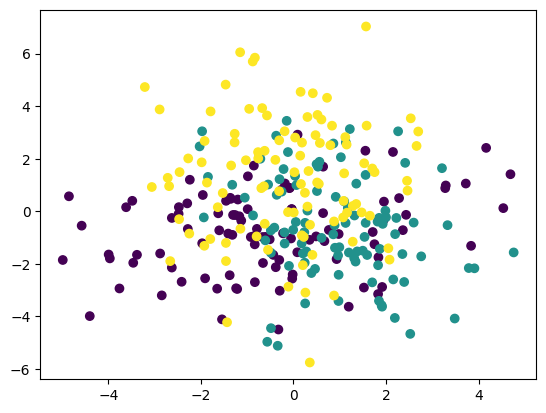

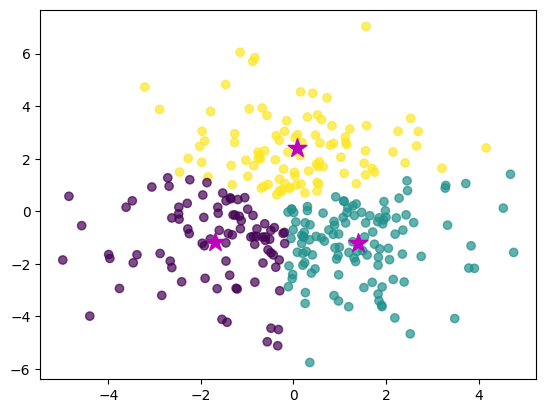

Sigma: 2	Accuracy: 0.58
Converged after 23 iterations.


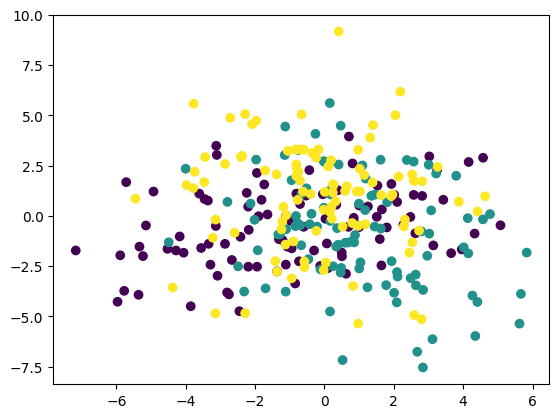

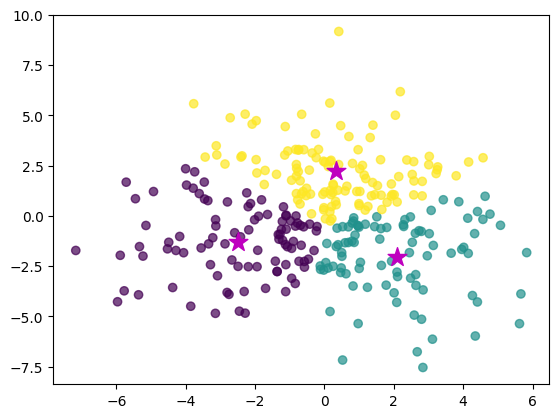

Sigma: 4	Accuracy: 0.52
Converged after 11 iterations.


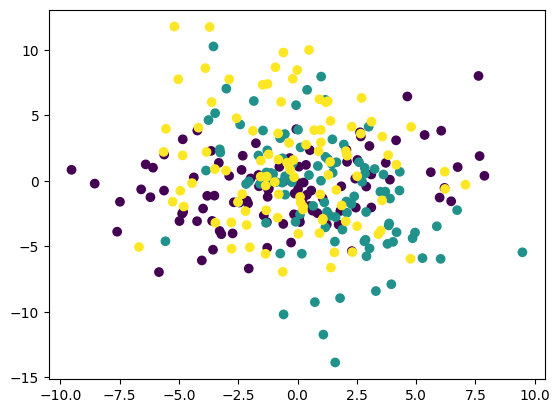

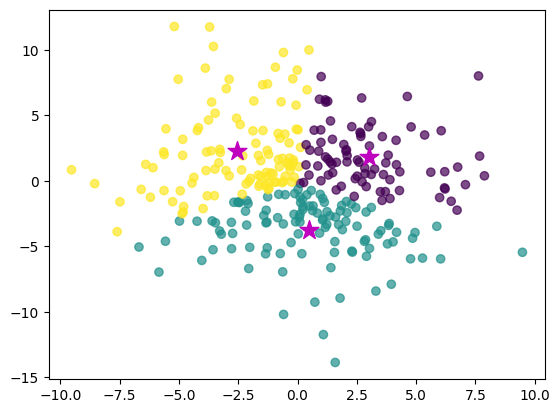

Sigma: 8	Accuracy: 0.37333333333333335


In [5]:
def calc_accuracy(Y, Yp):
    perms = list(permutations(np.unique(Y)))
    accuracies = []
    for perm in perms:
        num_correct = np.sum([1 if Y[i] == perm[Yp[i]] else 0 for i in range(len(Y))])
        accuracies.append(num_correct / len(Y))
    accuracies = np.array(accuracies)
    idx = np.argmax(accuracies)
    best_perm = np.array(perms[idx])
    best_acc = accuracies[idx]
    return (best_acc, best_perm)

for sigma in [0.01, 0.5, 1, 2, 4, 8]:
    k = 3
    X, Y = generate_dataset(sigma)
    centroids, Yhat = km_clustering(X, k)
    Yhat = Yhat.astype(int)
    acc, labels = calc_accuracy(Y, Yhat)
    Yhat = labels[Yhat.astype(int)]
    plt.scatter(x=X[:,0], y=X[:,1], c=Y)
    plt.show()
    plt.scatter(x=X[:,0], y=X[:,1], c=Yhat, alpha=0.7)
    plt.scatter(x=centroids[:,0], y=centroids[:,1], c='m', marker='*', s=200)
    plt.show()
    print('Sigma: ' + str(sigma) + '\tAccuracy: ' + str(acc))